![image.png](attachment:6fff0a5d-dd69-4c4c-adea-06273aaa74e2.png)

# Question 13

1. initialize
$w_0^{(j)} = \frac{g_0(x_0^{(j)})}{q(x_0^{(j)})}$

2. 状态采样 + 权重更新（对应 incremental weight）

PDF:
$$x_t^{(j)} \sim q(x_t \mid x_{0:t-1}^{(j)})
\quad\text{and}\quad
w_t^{(j)} = w_{t-1}^{(j)} \cdot \eta_t^{(j)}$$

其中：
$\eta_t^{(j)} := \frac{g(x_t^{(j)} \mid x_{t-1}^{(j)}) \cdot \zeta(y_t \mid x_t^{(j)})}{q(x_t^{(j)} \mid x_{0:t-1}^{(j)})}$

你这里用的提议分布 $q(x_t \mid x_{t-1}) = p(x_t \mid x_{t-1})$，也就是“自举滤波器”，所以：
$\eta_t^{(j)} = \zeta(y_t \mid x_t^{(j)})$
* 所以 incremental weight 就是观测似然 $p(y_t \mid x_t^{(j)})$。

3. 滤波估计（Filtering Estimate）

PDF:
$$\mathbb{E}[x_t \mid y_{1:t}]
\approx \sum_{j=1}^m \tilde{w}_t^{(j)} x_t^{(j)}$$

1. $g(x_t \mid x_{t-1})$：状态转移密度（State Transition / Prior Density）

这是指 系统状态的真实演化规律，即：
$$x_t \sim g(x_t \mid x_{t-1}) = p(x_t \mid x_{t-1})$$
这个函数 描述了系统自身的动力学规律，来源于你设定的“state equation”。

在你的问题中，状态模型为：
$$x_t = f(x_{t-1}, t) + u_t, \quad u_t \sim \mathcal{N}(0, 1)
\Rightarrow x_t \mid x_{t-1} \sim \mathcal{N}(f(x_{t-1}, t), 1)$$
所以：

你的 $g(x_t \mid x_{t-1})$ 是一个高斯密度函数，其均值是 $f(x_{t-1}, t)$，方差为 1。

2. $q(x_t \mid x_{0:t-1})$：提议分布（Proposal Distribution）

在 Importance Sampling 中，我们并不是直接从 $p(x_t \mid y_{1:t})$ 抽样，而是从一个较容易采样的分布 $q(x_t \mid x_{0:t-1})$ 中采样。

通常的选择是：
$$q(x_t \mid x_{0:t-1}) = g(x_t \mid x_{t-1})$$
也就是说：
提议分布就是直接用状态转移分布来提议采样（称为“Bootstrap filter”）。

这是因为：
* 从 $g(x_t \mid x_{t-1})$ 采样容易；
* 如果 $q = g$，那么权重更新会简化为：
$$w_t^{(j)} \propto w_{t-1}^{(j)} \cdot p(y_t \mid x_t^{(j)})$$

你题目中给出的观测模型是：
$$y_t = \frac{x_t^2}{20} + v_t, \quad v_t \sim \mathcal{N}(0, 1)$$
说明：
$$y_t \mid x_t \sim \mathcal{N}\left(\frac{x_t^2}{20}, 1\right)$$

所以你的 ζ 函数就是：
$$\zeta_t(y_t \mid x_t) = \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{1}{2} \left(y_t - \frac{x_t^2}{20}\right)^2\right)$$
也就是一个正态密度函数，其：
* 均值：$\mu = \frac{x_t^2}{20}$
* 方差：$\sigma^2 = 1$

“filter” 的意思是：用当前以及过去的信息来估计当前状态。
“smoothing” 的意思是：我们借助未来的信息 $y_{t+1}, y_{t+2}, \dots$ 来估计当前或过去的状态。

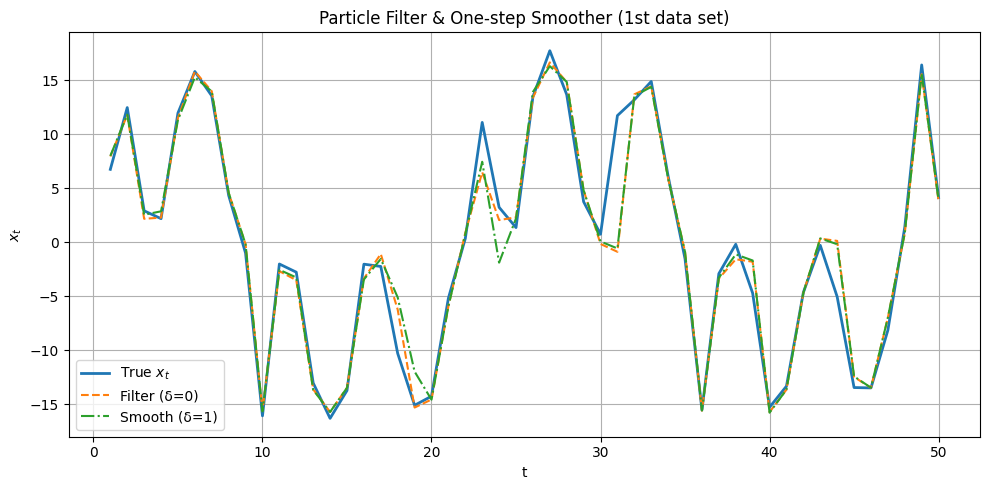

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import norm

# ---------- 0‑1 读取数据 ----------
def read_hw_data(file_path: str, T_full: int = 54):
    X_rows, Y_rows, current = [], [], None
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            toks  = line.split()
            label = toks[0] if toks[0] in ("X", "Y") else ("X" if current != "X" else "Y")
            nums  = list(map(float, toks[1:] if toks[0] in ("X","Y") else toks))
            while len(nums) < T_full:
                nums.extend(map(float, next(f).split()))
            (X_rows if label == "X" else Y_rows).append(np.asarray(nums))
            current = label
    return np.vstack(X_rows), np.vstack(Y_rows)   # (100,54)

# ---------- 0‑2 转移函数 ----------
def f_state(x_prev, t):
    return 0.5*x_prev + 25*x_prev/(1+x_prev**2) + 8*np.cos(1.2*(t-1))

prod = 1
# ---------- 0‑3 PF + fixed‑lag smoother (δ_max ≤ 4) ----------
import numpy as np
from scipy.stats import norm

def pf_smoother(y, T, delta_max=4, m=1000, resample=True):
    """
    Particle Filter + fixed‑lag smoother (δ ≤ 4)
    采用“累乘权重”真权重 true_wts，并在重采样后重置为均匀。
    """
    T_full = T + delta_max
    particles = np.zeros((T_full+1, m))
    ancestors = np.zeros((T_full+1, m), dtype=int)

    # two sets of weights
    true_wts  = np.zeros((T_full+1, m))     # 用于后验期望 (永远累乘)
    samp_wts  = np.zeros((T_full+1, m))     # 用于 ESS & 重采样

    particles[0] = 0.0
    true_wts[0]  = 1.0 / m                  # 均匀
    samp_wts[0]  = 1.0 / m

    E_filt   = np.zeros(T)
    E_smooth = {d: np.full(T, np.nan) for d in range(1, delta_max+1)}
    rng = np.random.default_rng()

    for t in range(1, T_full+1):
        # ----- 状态传播 -----
        x_pred = f_state(particles[t-1], t) + rng.normal(size=m)

        # ----- 累乘真权重 -----
        eta         = norm.pdf(y[t-1], loc=x_pred**2/20, scale=1.0)
        true_wts[t] = true_wts[t-1] * eta
        true_wts[t] /= true_wts[t].sum()            # 归一化

        # ----- 默认采样权重 = 真权重 -----
        samp_wts[t]  = true_wts[t]
        particles[t] = x_pred
        ancestors[t] = np.arange(m)

        # ----- 过滤估计 (δ=0) -----
        if t <= T:
            E_filt[t-1] = np.sum(true_wts[t] * x_pred)

        # ----- ESS & 重采样 -----
        ess = 1.0 / np.sum(samp_wts[t]**2)
        if resample and ess < 0.5 * m:
            cum = np.cumsum(samp_wts[t])
            idx = np.searchsorted(cum, rng.random()/m + np.arange(m)/m)

            particles[t] = particles[t][idx]        # 重排粒子
            ancestors[t] = idx

            samp_wts[t]  = 1.0 / m                  # 重采样后采样权重重置
            true_wts[t]  = 1.0 / m                  # 真权重也重置为均匀 (重新开始累乘)

    # ----- fixed‑lag smoothing -----
    for d in range(1, delta_max+1):
        for t in range(1, T+1):
            idx = np.arange(m)
            for _ in range(d):                      # 回溯 d 层祖先链
                idx = ancestors[t+_][idx]
            E_smooth[d][t-1] = np.sum(true_wts[t+d] * particles[t][idx])

    return E_filt, E_smooth

# ---------- 路径设置 ----------
file_path = Path("/Users/dongwenou/Downloads/Statistical Computing/HW_chapter4_13_2025.txt")

# ---------- 读取第 1 条 (l=0) ----------
X_all, Y_all = read_hw_data(file_path)       # (100,54)
x_true = np.concatenate(([0.0], X_all[0]))   # 补 x0=0 → 长 55
y_obs  = Y_all[0]                            # 长 54

# ---------- 运行 PF+Smoother (δ_max=1) ----------
E_filt, E_smooth = pf_smoother(y_obs, T=50, delta_max=1, m=1000, resample=True)

# ---------- 画图 ----------
t = np.arange(1, 51)
plt.figure(figsize=(10,5))
plt.plot(t, x_true[1:51], lw=2, label="True $x_t$")
plt.plot(t, E_filt, '--', label="Filter (δ=0)")
plt.plot(t, E_smooth[1], '-.', label="Smooth (δ=1)")
plt.xlabel('t'); plt.ylabel('$x_t$')
plt.title('Particle Filter & One‑step Smoother (1st data set)')
plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

In [114]:
# ----------------------------------------------------------
#  Step‑2  : RMSE(δ)  for δ = 0,1,2,3,4    (100 data sets)
#            — compare  resample=True  vs  False
# ----------------------------------------------------------

T          = 50
delta_max  = 4             # δ up to 4
m_particles = 1000         # 每条数据内部的粒子数

# ---------- 1. 读 100 条 (X, Y) ----------
file_path = Path("/Users/dongwenou/Downloads/Statistical Computing/HW_chapter4_13_2025.txt")
X_all, Y_all = read_hw_data(file_path)   # shape = (100, 54)

# ---------- 2. 初始化 RMSE 累积器 ----------
rmse_resample    = np.zeros(delta_max+1)   # δ = 0..4
rmse_no_resample = np.zeros(delta_max+1)

# ---------- 3. 循环 100 条数据 ----------
for l in range(100):
    x_true = np.concatenate(([0.0], X_all[l]))   # 补 x0=0  → 长 55
    y_obs  = Y_all[l]                            # 长 54

    # ---- (a) 带重采样 ----
    Ef, Es = pf_smoother(y_obs, T, delta_max, m_particles, resample=True)
    preds  = {0: Ef, **{d: Es[d] for d in range(1, delta_max+1)}} #字典的解包导入另一字典写法，等价于：
                                                                                            # preds = {}
                                                                                            # preds[0] = Ef
                                                                                            # for d in range(1, delta_max+1):
                                                                                            #     preds[d] = Es[d]
    for d in range(delta_max+1):
        rmse_resample[d] += np.mean((preds[d] - x_true[1:51])**2)

    # ---- (b) 不重采样 ----
    Ef, Es = pf_smoother(y_obs, T, delta_max, m_particles, resample=False)
    preds  = {0: Ef, **{d: Es[d] for d in range(1, delta_max+1)}}
    for d in range(delta_max+1):
        rmse_no_resample[d] += np.mean((preds[d] - x_true[1:51])**2)

# ---------- 4. 均值后开方 ----------
rmse_resample     = np.sqrt(rmse_resample    / 100)
rmse_no_resample  = np.sqrt(rmse_no_resample / 100)

# ---------- 5. 打印结果 ----------
print("RMSE(δ)  δ=0..4  【带重采样】 :", rmse_resample)
print("RMSE(δ)  δ=0..4  【不重采样】 :", rmse_no_resample)

RMSE(δ)  δ=0..4  【带重采样】 : [2.9802426  3.06861424 1.40367754 2.11273455 2.53017765]
RMSE(δ)  δ=0..4  【不重采样】 : [4.75095047 2.84538107 2.35821158 2.26923248 2.18160555]


$$
T(x, y) = \underbrace{q(y \mid x)}{\text{提议}} \cdot \underbrace{\min\left(1, \frac{f(y) q(x \mid y)}{f(x) q(y \mid x)} \right)}{\text{接受概率}}
$$


$$
q(x \mid x{\prime}) = \text{the probability of proposing \( x \) from \( x{\prime} \)}
$$

$$
\min\left\{ 1,\
\frac{f(X_i^* \mid X_{-i}^{(t)}) \cdot q(X_i^{(t-1)} \mid X_{-i}^{(t)}, X_i^*)}
{f(X_i^{(t-1)} \mid X_{-i}^{(t)}) \cdot q(X_i^* \mid X_{-i}^{(t)}, X_i^{(t-1)})}
\right\}
$$
$X_{-i}^{(t)}$ 表示除了第 $i$ 个变量以外，其它变量都按当前的最新值 $(X_1^{(t)}, \dots, X_{i-1}^{(t)}, X_{i+1}^{(t-1)}, \dots, X_n^{(t-1)})$；


$$
p(z_0 \mid \cdots) \propto
\underbrace{\mathcal{N}(z_0 \mid \mu_0, \eta_0^2)}{\text{prior}}
\cdot
\underbrace{\mathcal{N}(z_1 \mid b_0 + b_1 z_0, \delta^2)}{\text{transition likelihood}}
$$

由于：
$$
z_t \mid z_{t-1}, \mathbf{b} \sim \mathcal{N}(b_0 + b_1 z_{t-1}, \delta^2)
$$
所以：
$$
p(z_t \mid z_{t-1}, \mathbf{b}, \delta^2) \propto \exp\left( -\frac{1}{2\delta^2} (z_t - b_0 - b_1 z_{t-1})^2 \right)
$$
我们将 $b_0 + b_1 z_{t-1}$ 写成 $(1, z_{t-1}) \mathbf{b}$，这样写更紧凑。

于是：

$$\prod_{t=1}^T p(z_t \mid z_{t-1}, \mathbf{b}, \delta^2) \propto \exp\left( -\frac{1}{2\delta^2} \sum_{t=1}^T (z_t - (1, z_{t-1}) \mathbf{b})^2 \right)$$